In [1]:
%cd ~/bioinfo1/project/

/rna/hyemin/bioinfo1/project


### gsnap/star, 35L33G/2J3/Polyclonal 각 combination에 대해 아래 분석을 반복 진행

(cell 안 단어를 바꿔가며 여러번 돌렸기에, notebook에는 gsnap-Polyclonal 쌍만 남겨놓음)

##### Base positions with cut-offs of 0.8 for crosslinking-induced reverse-transcription error score (CRES) and 50 for read depth.

In [92]:
!samtools mpileup --ff 3860 CLIP/alignments/gsnap/CLIP-Polyclonal.bam | \
    awk '$4 >= 50 {print $0}'> CLIP/motif/gsnap/CLIP-Polyclonal-ge50-plus.pileup
!wc -l CLIP/motif/gsnap/CLIP-Polyclonal-ge50-plus.pileup # filter out QC failed, unmapped, secondary, supplementary, and duplicate reads # plus strand

[mpileup] 1 samples in 1 input files
18716334 CLIP/motif/star/CLIP-35L33G-ge50-plus.pileup


In [93]:
!samtools mpileup --ff 3844 --rf 16 CLIP/alignments/gsnap/CLIP-Polyclonal.bam | \
    awk '$4 >= 50 {print $0}'> CLIP/motif/gsnap/CLIP-Polyclonal-ge50-minus.pileup
!wc -l CLIP/motif/gsnap/CLIP-Polyclonal-ge50-minus.pileup # filter out QC failed, unmapped, secondary, supplementary, and duplicate reads # minus strand

[mpileup] 1 samples in 1 input files


16242941 CLIP/motif/star/CLIP-35L33G-ge50-minus.pileup


In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [95]:
lNames = ['chrom', 'pos', '_ref', 'count', 'basereads', 'quals']
toremove = re.compile('[<>$]|\^.') # [문자들] : 문자들 중 하나와 매치

In [96]:
lFiles = ['CLIP/motif/gsnap/CLIP-Polyclonal-ge50-plus.pileup', 'CLIP/motif/gsnap/CLIP-Polyclonal-ge50-minus.pileup']

In [97]:
for file in lFiles:
    dfPileup = pd.read_csv(file, sep='\t', names=lNames)
    dfPileup['matchesNdel'] = dfPileup['basereads'].apply(lambda x: toremove.sub('', x)) # remove special characters (<>$^.) from basereads
    dfPileup['AGCTD'] = dfPileup['matchesNdel'].apply(lambda x: np.array((x.count('A') + x.count('a'), \
                                                                      x.count('G') + x.count('g'), \
                                                                      x.count('C') + x.count('c'), \
                                                                      x.count('T') + x.count('t'), \
                                                                      x.count('*') + x.count('#'))))
    dfPileup['entropy'] = dfPileup['AGCTD'].apply(lambda x: -sum([i*np.log2(i) for i in x/sum(x) if i > 0])).replace(-0.0, 0.0)
    dfPileup['start'] = dfPileup['pos'] - 1
    dfPileup[dfPileup['entropy'] >= 0.8][['chrom', 'start', 'pos', 'entropy']].to_csv(file[:-len('.pileup')] + '.entropy.BedGraph', sep='\t', index=False, header=False)

##### Neighboring sequences of the high-mutated bases in reference genome (mm39).

In [10]:
!wget -P ~/bioinfo1/project/binfo1-datapack1 https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_mouse/release_M35/GRCm39.primary_assembly.genome.fa.gz
!gunzip ~/bioinfo1/project/binfo1-datapack1/GRCm39.primary_assembly.genome.fa.gz

--2024-05-24 23:48:06--  https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_mouse/release_M35/GRCm39.primary_assembly.genome.fa.gz
Resolving ftp.ebi.ac.uk (ftp.ebi.ac.uk)... 193.62.193.165
Connecting to ftp.ebi.ac.uk (ftp.ebi.ac.uk)|193.62.193.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 773873008 (738M) [application/x-gzip]
Saving to: ‘/rna/hyemin/bioinfo1/project/binfo1-datapack1/GRCm39.primary_assembly.genome.fa.gz’

GRCm39.primary_asse 100%[===================>] 738.02M   194KB/s    in 60m 44s 

2024-05-25 00:48:51 (207 KB/s) - ‘/rna/hyemin/bioinfo1/project/binfo1-datapack1/GRCm39.primary_assembly.genome.fa.gz’ saved [773873008/773873008]



In [11]:
!rsync -avz ~/bioinfo1/project/binfo1-datapack1/GRCm39.primary_assembly.genome.fa ./

sending incremental file list
GRCm39.primary_assembly.genome.fa

sent 830,138,257 bytes  received 35 bytes  40,494,550.83 bytes/sec
total size is 2,773,693,944  speedup is 3.34


In [98]:
!awk -F'\t' -v OFS='\t' '{print $1, $2-15, $3+15,  $1 "_" $2 "_" $3, ".", "+"}' CLIP/motif/gsnap/CLIP-Polyclonal-ge50-plus.entropy.BedGraph >> CLIP/motif/gsnap/CLIP-Polyclonal-mut-neighbor15.bed
!awk -F'\t' -v OFS='\t' '{print $1, $2-15, $3+15,  $1 "_" $2 "_" $3, ".", "-"}' CLIP/motif/gsnap/CLIP-Polyclonal-ge50-minus.entropy.BedGraph >> CLIP/motif/gsnap/CLIP-Polyclonal-mut-neighbor15.bed

In [99]:
!bedtools getfasta -fi binfo1-work/GRCm39.primary_assembly.genome.fa -bed CLIP/motif/gsnap/CLIP-Polyclonal-mut-neighbor15.bed -s -name | tr 'T' 'U' > CLIP/motif/gsnap/CLIP-Polyclonal-mut-neighbor15-seq.fa

In [100]:
with open('CLIP/motif/gsnap/CLIP-Polyclonal-mut-neighbor15-seq.fa') as fIn, open('CLIP/motif/gsnap/CLIP-Polyclonal-mut-neighbor15-seq-G.fa', 'w') as fOut: # save only the sequences with G at the 16th position
    lines = fIn.readlines()
    for line in lines:
        if line.startswith('>'):
            header = line.strip()
        else:
            seq = line.strip()
            if seq[15] == 'G':
                fOut.write(header + '\n')
                fOut.write(seq + '\n')

In [6]:
with open('CLIP/motif/gsnap/CLIP-Polyclonal-mut-neighbor15-seq-G.fa', 'r') as fIn, open('CLIP/motif/gsnap/CLIP-Polyclonal-mut-neighbor5-seq-G.fa', 'w') as fOut: # save only the sequences with G at the 16th position
    lines = fIn.readlines()
    for line in lines:
        if line.startswith('>'):
            header = line.strip()
            fOut.write(header + '\n')
        else:
            seq = line.strip()
            fOut.write(seq[10:21] + '\n')

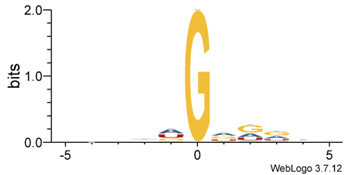
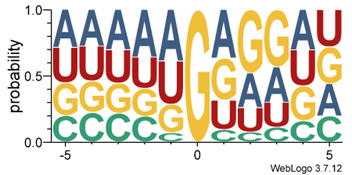

In [101]:
with open('CLIP/motif/gsnap/CLIP-Polyclonal-mut-neighbor15-seq-G.fa', 'r') as fIn, open('CLIP/motif/gsnap/CLIP-Polyclonal-mut-around6-seq-G.fa', 'w') as fOut: # save only the sequences with G at the 16th position
    lines = fIn.readlines()
    for line in lines:
        if line.startswith('>'):
            header = line.strip()
            fOut.write(header + '\n')
        else:
            seq = line.strip()
            fOut.write(seq[13:19] + '\n')

In [15]:
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from collections import Counter

In [84]:
with open('CLIP/motif/gsnap/CLIP-Polyclonal-mut-around6-seq-G.fa', 'r') as f:
    lines = f.readlines()
    seqs = [line.strip() for line in lines if not line.startswith('>')]
    cSeqs = Counter(seqs)

In [85]:
dTop15 = dict(cSeqs.most_common(15))
iAllCount = sum(cSeqs.values())
for k, v in dTop15.items():
    dTop15[k] = v / iAllCount * 100

In [86]:
dTop15

{'AAGGAG': 1.6913358403882848,
 'AAGAAG': 1.3597376854819287,
 'AAGAGA': 1.2448824586428557,
 'GAGGAG': 1.2078323854689612,
 'AAGAGG': 1.068894611066857,
 'AAGGUG': 1.020729515940794,
 'UGGAGA': 0.8725292232452159,
 'GAGAGA': 0.8484466756821845,
 'AGGAGA': 0.8132491061669846,
 'AAGAUG': 0.7854615512865638,
 'GAGAAG': 0.750263981771364,
 'AAGAAA': 0.7132139085974695,
 'CAGAGA': 0.7113614049387748,
 'UUGUGU': 0.6761638354235749,
 'UUGUGA': 0.635408754932291}

In [87]:
G = nx.Graph()
for seq, freq in dTop15.items():
    G.add_node(seq, size=freq)

In [88]:
def hamming(s1, s2):
    return sum(ch1 != ch2 for ch1, ch2 in zip(s1, s2))

In [89]:
for seq1 in dTop15.keys():
    for seq2 in dTop15.keys():
        if hamming(seq1, seq2) == 1:
            G.add_edge(seq1, seq2)

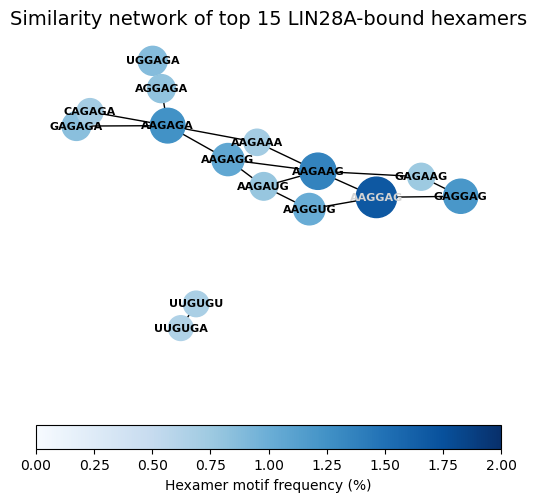

In [110]:
fig, ax = plt.subplots(figsize=(6, 6))
node_sizes = np.array([G.nodes[node]['size'] for node in G.nodes])
norm = plt.Normalize(vmin=0, vmax=2)
node_colors = cm.Blues(norm(node_sizes))
pos = nx.spring_layout(G)  # Choose a layout
nx.draw(G, pos, with_labels=False, node_size=node_sizes*500, node_color=node_colors, cmap=plt.cm.Blues)

# Draw node labels with conditional coloring
for node, (x, y) in pos.items():
    color = 'lightgray' if G.nodes[node]['size'] > 1.5 else 'black'
    plt.text(x, y, node, fontsize=8, fontweight='bold', ha='center', va='center', color=color)

# Set colorbar
sm = plt.cm.ScalarMappable(cmap=cm.Blues, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='horizontal')
cbar.set_label('Hexamer motif frequency (%)')

# Set title
ax.set_title('Similarity network of top 15 LIN28A-bound hexamers', fontsize=14)

plt.show()
